In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import time
%matplotlib inline  

In [15]:
x = 3
z = 4
R = np.sqrt(x**2+z**2)
B = 6

In [16]:
#Check at t=R/B -> p=x/RB
p = complex(x/(R*B),0)
w = p.real
y = p.imag

In [5]:
#Check at t>R/B -> p=x/RB + eps
p = complex(x/(R*B),0.01)
w = p.real
y = p.imag

In [18]:
t1 = w*x + 1j*y*x + np.sqrt(B**-2 - w**2 - 2*1j*w*y + y**2)*z #works
t2 = np.sqrt(((w**2+2*1j*w*y-y**2)*R**4 - (z*R/B)**2)/(x**2-z**2)) #doesn't work
t3 = np.sqrt((p*R**4-(z*R/B)**2)/(x**2-z**2)) #REALLY doesn't work
t4 = p*x + np.sqrt(B**-2-p**2)*z #works
print "t1: ", t1
print "t2: ", t2
print "t3: ", t3
print "t4: ", t4

t1:  (0.833333333333+0j)
t2:  (0.833333333333-0j)
t3:  -2.70947778018j
t4:  (0.833333333333+0j)


In [7]:
#Take t=R/B + eps, find a valid p
t = R/B 
p = (x*t + 1j*z*np.sqrt(t**2-(R/B)**2))/R**2
print p
print t
w = p.real
y = p.imag

(0.1+0j)
0.833333333333


# Method 1

Eq. (6.50) gives p(t) for $t\geq \frac R \beta$. Just use that up to a max t value.

In [2]:
#Method 1: grid real t, find p values using (6.50)
def p_from_t(x, z, B, tmax):
    R = np.sqrt(x**2+z**2)
    t = np.linspace(R/B,tmax,1000)
    p = (x*t + 1j*z*np.sqrt(t**2-(R/B)**2))/R**2
    return p

comp time:  0.0557191371918 s


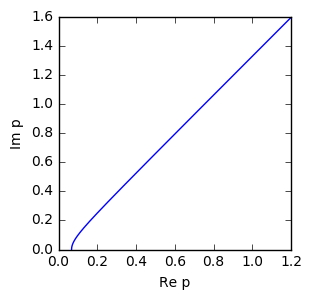

In [3]:
ts = time.time()
p1 = p_from_t(3,4,9,10)
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(p1.real,p1.imag)
tf = time.time()-ts
print "comp time: ", tf, "s"
ax.set_xlabel("Re p")
ax.set_ylabel("Im p")
plt.show()

# Method 2

Eq. (6.49) gives $t(p) = px + \eta |z|$ and we know $\eta = \sqrt{\beta^{-2}-p^2}$. Thus, $t = px+\sqrt{\beta^{-2}-p^2}|z|$.

We can take $p = w+i y$ to find t in terms of Re p and Im P coordinates, which we can then grid and search. We know $p=\frac{x}{R\beta}$ at $t=\frac R \beta$. Start there and examine a small grid in the p plane to find the direction of max increasing real t.

In [122]:
def t_from_p(x, z, B, tmax):
    R = np.sqrt(x**2+z**2)
    t = [R/B]
    p = [x/(R*B)+0*1j]
    
    def t_func(p1):
        return p1*x + np.sqrt(B**-2-p1**2)*z
    
    while t[-1] < tmax:
#     step=0
#     while step < steps:
        w0 = p[-1].real
        y0 = p[-1].imag
        coords = []
        for n in range(1,10):
            for m in range(1,10):
                w = w0 + n*.00001
                y = y0 + m*.00001
                coords.append((w,y))
        tvals = [t_func(complex(*coord)) for coord in coords]
#         tnew = max([tv for tv in tvals if (abs(tv.imag)-y0)<.15])
        t_ind = np.argmax([abs(tv) for tv in tvals])
#         t_ind = tvals.index(tnew)
        t.append(abs(tvals[t_ind]))
        p.append(complex(*coords[t_ind]))
#         step+=1
    
    p0 = np.linspace(0,x/(R*B),250)
    t[:0] = t_func(p0)
    p[:0] = p0
    
    return t, np.array(p)

comp time:  0.681168794632 s


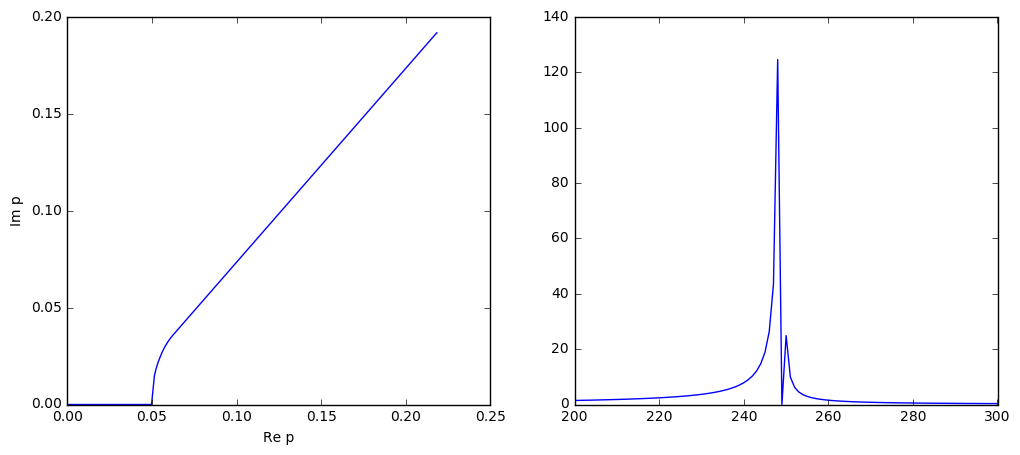

In [135]:
ts = time.time()
t2, p2 = t_from_p(3,6,9,2)
fig, ax = plt.subplots(1, 2, figsize = (12, 5))
# axs = [[0, 1], [0, 2]]
ax[0].plot(p2.real,p2.imag)
tf = time.time()-ts
print "comp time: ", tf, "s"
ax[0].set_xlabel("Re p")
ax[0].set_ylabel("Im p")
ax[0].set_xlim(left=0)

ax[1].plot(np.diff(p2)/(np.diff(t2)+.0000001))
ax[1].set_xlim([200, 300])
plt.show()

In [109]:
t2[-1]

2.0001533710656405